<a href="https://colab.research.google.com/github/zhichucode/Audio/blob/master/MIMII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The dataset MIMII anylize

### Download the dataset of fan sound

In [ ]:
!wget https://zenodo.org/record/3384388/files/0_dB_fan.zip?download=1

--2022-03-08 07:03:18--  https://zenodo.org/record/3384388/files/0_dB_fan.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10411902283 (9.7G) [application/octet-stream]
Saving to: ‘0_dB_fan.zip?download=1’

0_dB_fan.zip?downlo 100%[===================>]   9.70G  29.7MB/s    in 10m 19s 

2022-03-08 07:13:38 (16.0 MB/s) - ‘0_dB_fan.zip?download=1’ saved [10411902283/10411902283]



In [ ]:
# get the github repo for start this dataset

!git clone https://github.com/MIMII-hitachi/mimii_baseline.git

Cloning into 'mimii_baseline'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 79 (delta 41), reused 30 (delta 10), pack-reused 0
Unpacking objects: 100% (79/79), done.


In [ ]:
!7z -o{/content/fan} -y x /content/0_dB_fan.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 10411902283 bytes (9930 MiB)

Extracting archive: /content/0_dB_fan.zip
 73% 4096 Open              --
Path = /content/0_dB_fan.zip
Type = zip
Physical Size = 10411902283
64-bit = +

  0%      0% 8 - fan/id_00/abnormal/00000005.wav                                          0% 13 - fan/id_00/abnormal/00000010.wav                                           0% 18 - fan/id_00/abnormal/00000015.wav                                         

In [ ]:
mv /content/{/content/fan}/fan /content/fan

In [ ]:
rm -rf /content/{

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


## Anaylize the sounds

In [ ]:
import librosa

#load the audio file
AUDIO_FILE = '/content/fan/id_00/abnormal/00000000.wav'
samples, sample_rate = librosa.load(AUDIO_FILE, sr=None)
print("sample rate: " + str(sample_rate))

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: ignored

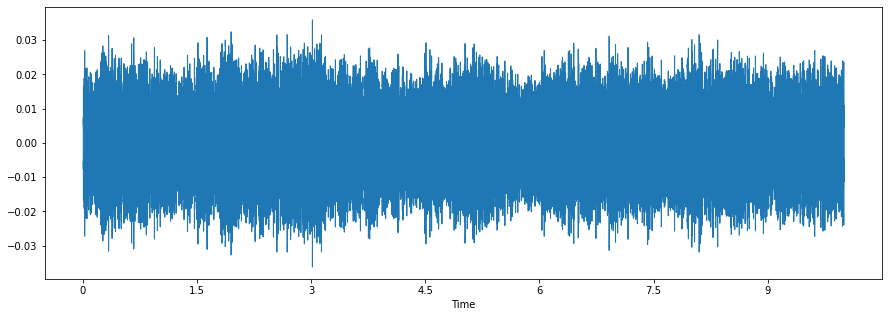

In [ ]:
import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
librosa.display.waveshow(samples, sr=sample_rate)

In [ ]:
from IPython.display import Audio
Audio(AUDIO_FILE)

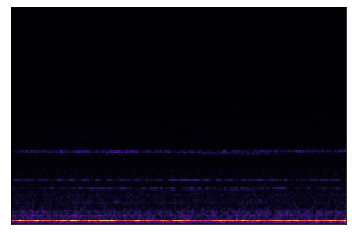

In [ ]:
sgram = librosa.stft(samples)
sgram_mag, _ = librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
librosa.display.specshow(mel_scale_sgram)

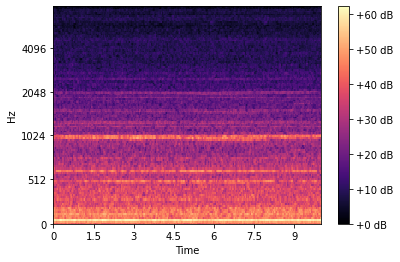

In [ ]:
import numpy as np
mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
librosa.display.specshow(mel_sgram, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

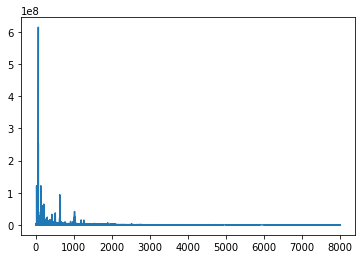

In [ ]:
from scipy.fft import rfft, rfftfreq
import numpy as np

N = len(samples)
normalized_tone = np.int16((samples / samples.max()) * 32767)
yf = rfft(normalized_tone)
xf = rfftfreq(N, 1 / sample_rate)

plt.plot(xf, np.abs(yf))
plt.show()

## Build the deep learning model

The task now is writing the model to define the data and classify the audio 
between normal and abnormal.



### Roadmap

 1. convert the audio files into PNG format images(spectrograms)
 2. extract meaningful features, i.e. MFCCs, Spectral Centroid, Zero Crossing Rate, Chroma Frequencies, Spectral Roll-off.
 3. features be appended into a CSV file so that ANN can be used for classification.

### Note
tackle the sounds from the two types of files with "normal" and "abnormal". we can take it as "Cat vs. Dog Image Classification"

In [ ]:
# import needed modeule
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!cp -r /content/fan /content/drive/MyDrive

## From Dog vs. Cat calssification

v1: [dog vs. cat classification](https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part1.ipynb#scrollTo=H4XHh2xSfgie)

v2: add some [california housing data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/intro_to_neural_nets.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=intro_to_nn_tf2-colab&hl=en)




In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

### Prepare the training data, evaluate data and test data

In [ ]:
base_dir = '/content/drive/MyDrive/fan_audio_data'
train_dir = os.path.join(base_dir, 'id_02')
validation_dir = os.path.join(base_dir, 'id_02')

# Directory with our training sounds
train_normal_dir = os.path.join(train_dir, 'normal')
train_abnormal_dir = os.path.join(train_dir, 'abnormal')

# Directory with validation sounds
validation_normal_dir = os.path.join(validation_dir, 'normal')
validation_abnormal_dir = os.path.join(validation_dir, 'abnormal')

In [ ]:
train_normal_fnames = os.listdir(train_normal_dir)
print(train_normal_fnames[:10]) #fname = file names

train_abnormal_fnames = os.listdir(train_abnormal_dir)
train_abnormal_fnames.sort()
print(train_abnormal_fnames[:10])

['00000000.wav', '00000001.wav', '00000002.wav', '00000003.wav', '00000004.wav', '00000005.wav', '00000006.wav', '00000007.wav', '00000008.wav', '00000009.wav']
['00000000.wav', '00000001.wav', '00000002.wav', '00000003.wav', '00000004.wav', '00000005.wav', '00000006.wav', '00000007.wav', '00000008.wav', '00000009.wav']


In [ ]:
print('total training normal sounds: ', len(os.listdir(train_normal_dir)))

total training normal sounds:  141


### Define a model building function

In [ ]:
def create_model(learning_rate, input_dim):
    """
    define the keras model
    the model based on the simple dense auto encoder (64*64*8*64*64)
    """
    model = models.Sequential()

    model.add(input_dim)

    model.add(layers.Dense(units=64, activation='relu'))
    model.add(layers.Dense(units=64, activation='relu'))
    model.add(layers.Dense(units=8 , activation='relu'))
    model.add(layers.Dense(units=64, activation='relu'))
    model.add(layers.Dense(units=64, activation='relu'))
    model.add(layers.Dense(units=1))

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                # loss="mean_squared_error",
                loss=tf.keras.losses.BinaryCrossentropy(), # better for binary claasification
                metrics=[tf.keras.metrics.MeanSquaredError()])

    return model

### Define a training function

In [ ]:
def train_model(model, dataset, epochs, 
                batch_size=None):
  """
  model: the model
  dataset: the traing data
  epochs: 
  label_name:
  batch_size: If the data is very large, we can set up the batch size to avoid 
  it make the training faster.
  """

  # Split the dataset into features and label.
  features = 
  label = 
  history = model.fit(x=features, 
                      y=label, 
                      batch_size=batch_size,
                      epochs=epochs, 
                      shuffle=True) 

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # To track the progression of training, gather a snapshot
  # of the model's mean squared error at each epoch. 
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse


### Define a plotting function
The following matplotlib function plot shows how various classification metrics chang with each epoch.

In [ ]:
def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  

### Invoke the creating, training, and plotting functions
1. specify the hyperparameters
2. invokes the functions to create and train the model
3. plot the results.

In [ ]:
# Hyperparameters
learning_rate = 0.01
epochs = 15
batch_size = 20

# Establish the model's topography
audio_classification_model = create_model(learning_rate, input_dim)
model.summary()

# Train the model on the normalized training set.
epochs, mse = train_model(audio_classification_model, "dataset", epochs, batch_size)

# Plot a graph of the metrics vs. epochs
plot_the_loss_curve(epochs, mse)

### Evaluate the model against the test set

At the end of model training, you ended up with a certain accuracy against the training set. Invoke the following code cell to determine your model's accuracy against the test set.

In [ ]:
test_features = 
test_label = 
print("\n Evaluate the audio classification model against the test set: ")
audio_classification_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)